In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
import os

In [2]:
# DATA

# import

station_id=5001
file_path = os.path.join(r'D:\FMF magisterij\Matematika z računalnikom', f'ELES-MAS-{station_id}-2020-2023.csv.gz')
data = pd.read_csv(file_path, compression='gzip')
data = data[data['data_validity'] <= 32]
data.drop('measurement_location_inst_id', axis=1, inplace=True)
data['acquisition_timestamp'] = pd.to_datetime(data['acquisition_timestamp'], utc=True)


In [3]:
# pivoting
new_data = data.pivot_table(index='acquisition_timestamp', columns='parameter_type', values='value').reset_index()
new_data.set_index('acquisition_timestamp', inplace=True)


# solar_radiation_intensity
solar_radiation_intensity = new_data[['SOLAR_RADIATION_INTENSITY']]
print(solar_radiation_intensity)

# count the NaN values
nan_count_solar_radiation_intensity = solar_radiation_intensity['SOLAR_RADIATION_INTENSITY'].isna().sum()
print(nan_count_solar_radiation_intensity)
# there are no NaN values

# check for missing measurements (skipped times)
complete_range = pd.date_range(start=solar_radiation_intensity.index.min(), end=solar_radiation_intensity.index.max(), freq='5T')
missing_timestamps = complete_range.difference(solar_radiation_intensity.index)
print(len(missing_timestamps))
#print(complete_range)
df_complete_range = pd.DataFrame(index=complete_range)
len(df_complete_range)
# we have 271508 measurements, there are 5112 missing measurment out of 276620 time steps in the whole time range

# fill the missing measurements with the measurment at that time on the previous day (!problem: if the measurment of the previous day at that time is also missing. solution: take the next day)

# merge all the solar radiation intensity measurements with all the time steps. missing measurment will be NaN values for now
solar_radiation_intensity_incomplete = df_complete_range.merge(solar_radiation_intensity, left_index=True, right_index=True, how='left')
# print(solar_radiation_intensity_incomplete)
solar_radiation_intensity_incomplete.isna().sum() # okay

# missing measurements are filled with the next available measurement
solar_radiation_intensity_all = solar_radiation_intensity_incomplete.bfill()
print(solar_radiation_intensity_all)
solar_radiation_intensity_all.isna().sum() # okay

str(solar_radiation_intensity_all.index.dtype) # okay

parameter_type             SOLAR_RADIATION_INTENSITY
acquisition_timestamp                               
2020-10-13 10:20:00+00:00                      285.6
2020-10-13 10:25:00+00:00                      262.0
2020-10-13 10:30:00+00:00                      270.9
2020-10-13 10:35:00+00:00                      307.4
2020-10-13 10:40:00+00:00                      342.0
...                                              ...
2023-05-31 21:35:00+00:00                        0.0
2023-05-31 21:40:00+00:00                        0.0
2023-05-31 21:45:00+00:00                        0.0
2023-05-31 21:50:00+00:00                        0.0
2023-05-31 21:55:00+00:00                        0.0

[271508 rows x 1 columns]
0
5112
                           SOLAR_RADIATION_INTENSITY
2020-10-13 10:20:00+00:00                      285.6
2020-10-13 10:25:00+00:00                      262.0
2020-10-13 10:30:00+00:00                      270.9
2020-10-13 10:35:00+00:00                      307.4
2020-10-13 1

'datetime64[ns, UTC]'

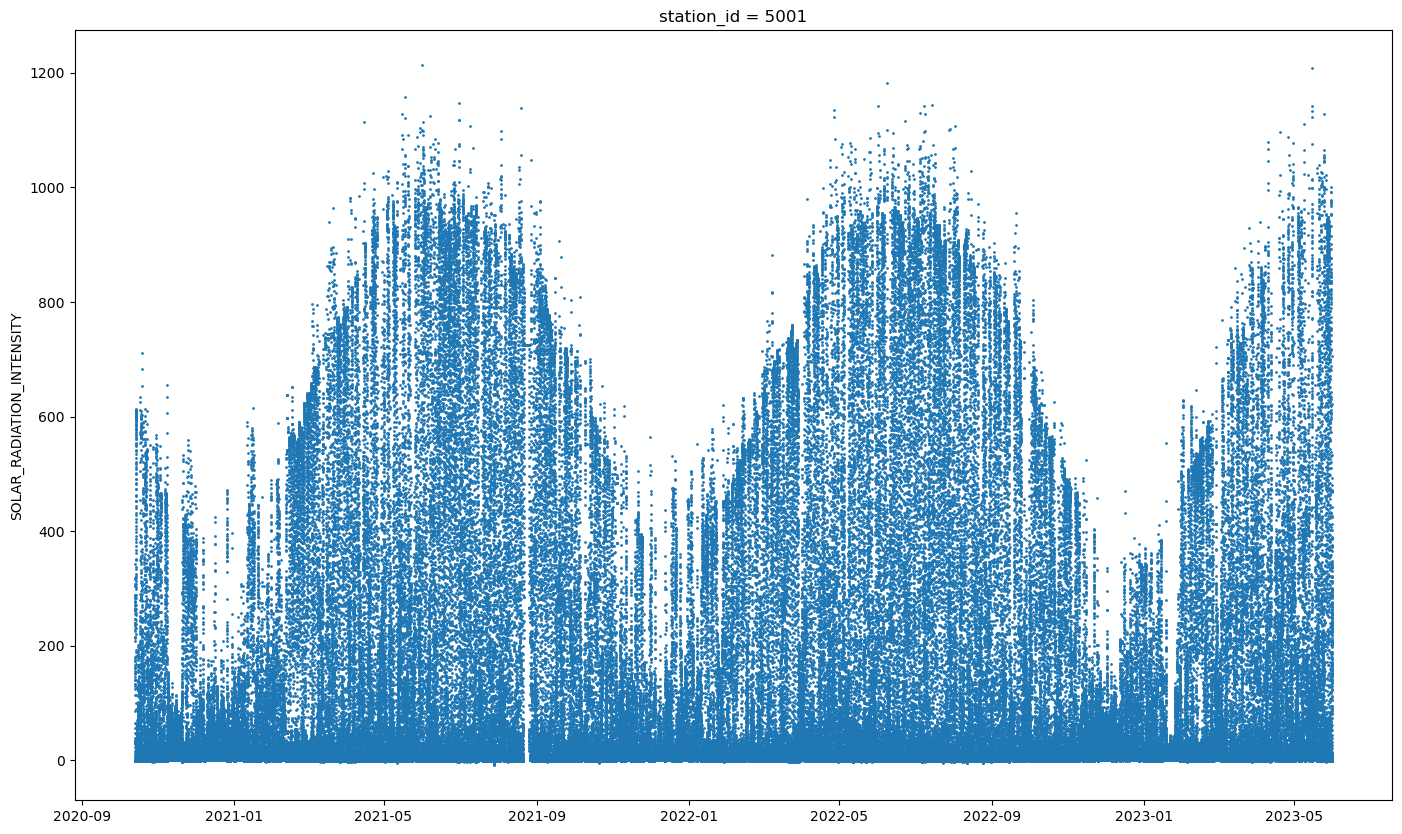

In [4]:
# plot 'SOLAR_RADIATION_INTENSITY'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(solar_radiation_intensity_all.index, solar_radiation_intensity_all['SOLAR_RADIATION_INTENSITY'],s=1)
ax.set_ylabel('SOLAR_RADIATION_INTENSITY')  
ax.set_title(f'station_id = {station_id}')  
plt.show()

                           SOLAR_RADIATION_INTENSITY
2020-10-13 10:00:00+00:00                 300.837500
2020-10-13 11:00:00+00:00                 258.341667
2020-10-13 12:00:00+00:00                 260.816667
2020-10-13 13:00:00+00:00                 161.950000
2020-10-13 14:00:00+00:00                 155.100000
...                                              ...
2023-05-31 17:00:00+00:00                  39.358333
2023-05-31 18:00:00+00:00                   4.341667
2023-05-31 19:00:00+00:00                  -0.766667
2023-05-31 20:00:00+00:00                   0.000000
2023-05-31 21:00:00+00:00                   0.000000

[23052 rows x 1 columns]


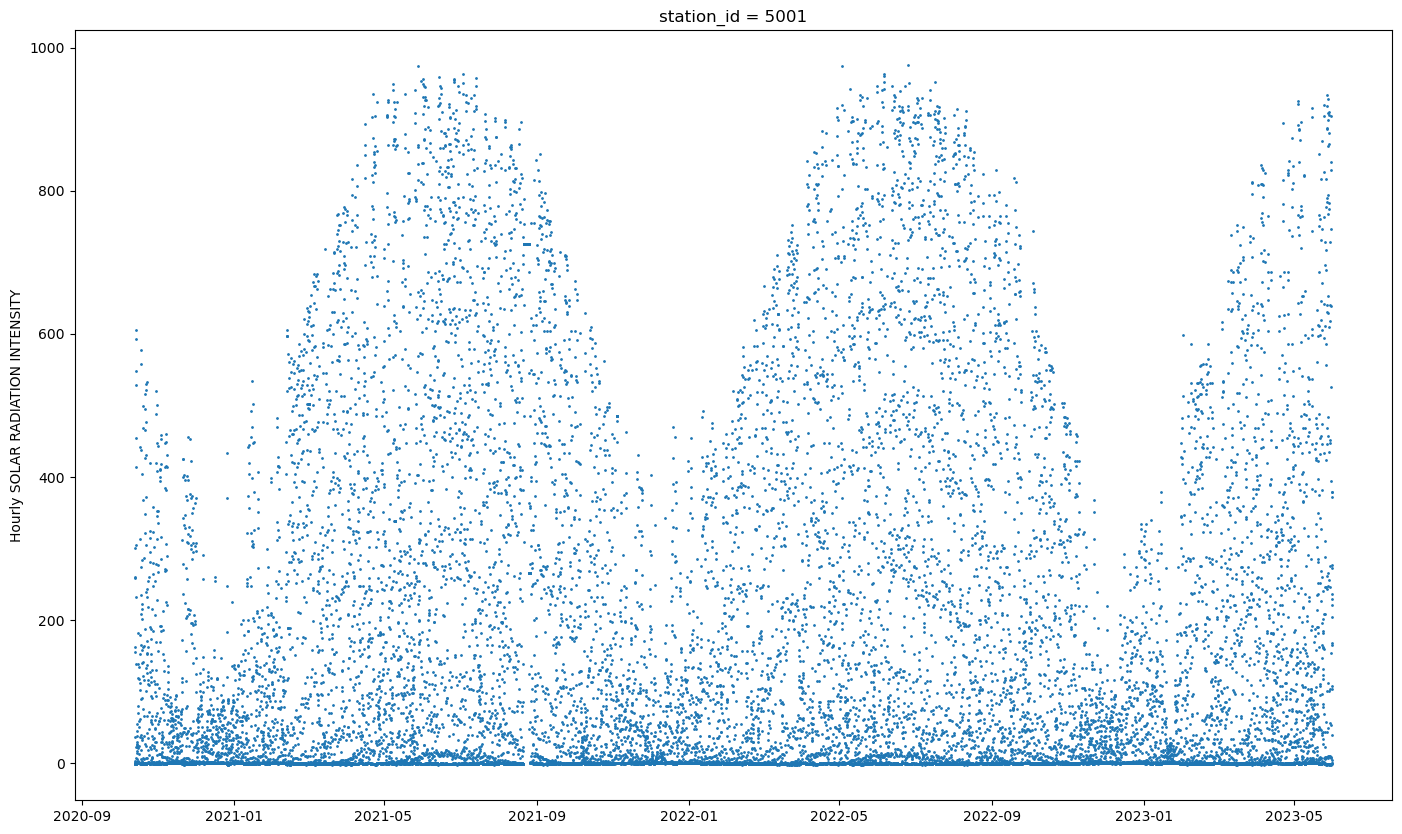

In [5]:
# hourly data
# sum the values for each hour and take the mean

str(solar_radiation_intensity_all.index.dtype) # okay
solar_radiation_intensity_hourly = solar_radiation_intensity_all.resample('H').mean()
print(solar_radiation_intensity_hourly)

# plot hourly 'SOLAR_RADIATION_INTENSITY'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(solar_radiation_intensity_hourly.index, solar_radiation_intensity_hourly['SOLAR_RADIATION_INTENSITY'],s=1)
ax.set_ylabel('Hourly SOLAR RADIATION INTENSITY')  
ax.set_title(f'station_id = {station_id}')  
plt.show()

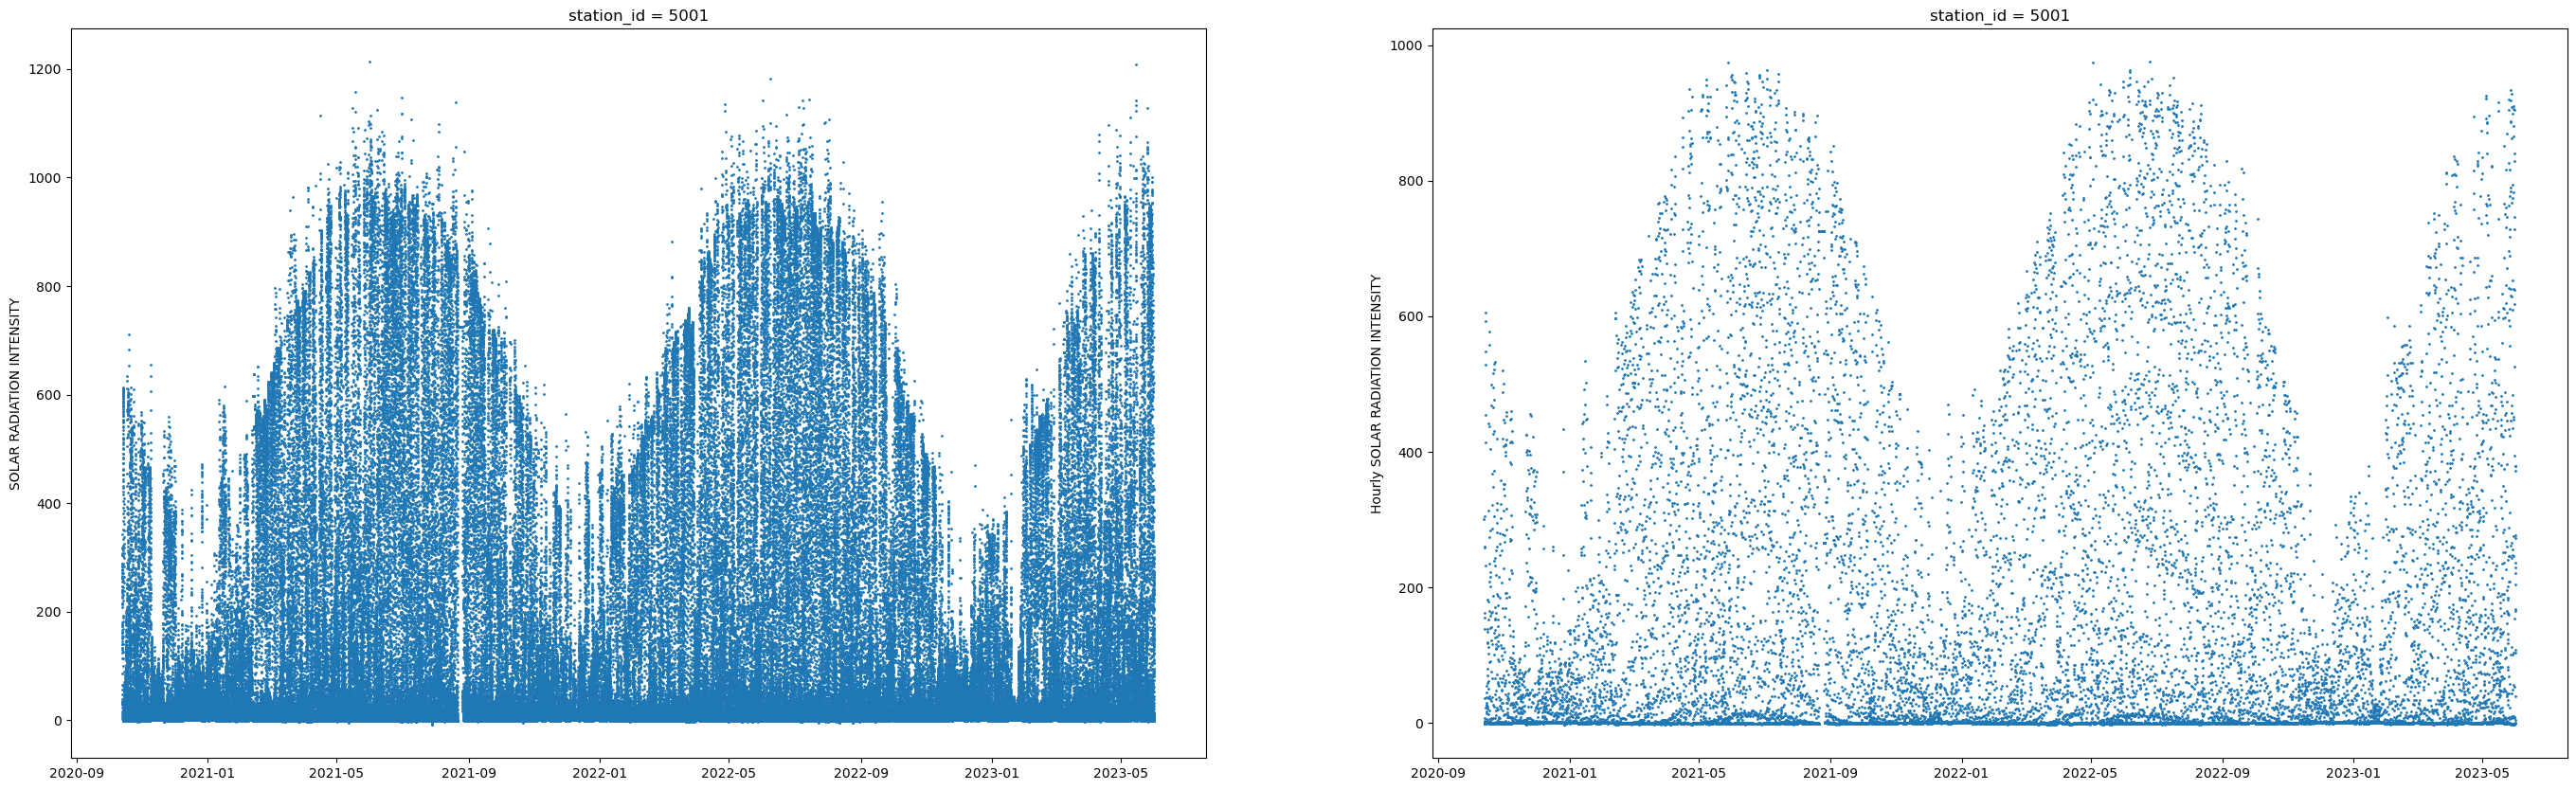

In [30]:
# plots side by side for the report

fig, axs = plt.subplots(1, 2, figsize=(34, 10))

# Plot 'SOLAR_RADIATION_INTENSITYE'
axs[0].scatter(solar_radiation_intensity_all.index, solar_radiation_intensity_all['SOLAR_RADIATION_INTENSITY'], s=1)
axs[0].set_ylabel('SOLAR RADIATION INTENSITY')
axs[0].set_title(f'station_id = {station_id}')

# Plot hourly 'SOLAR_RADIATION_INTENSITY'
axs[1].scatter(solar_radiation_intensity_hourly.index, solar_radiation_intensity_hourly['SOLAR_RADIATION_INTENSITY'], s=1)
axs[1].set_ylabel('Hourly SOLAR RADIATION INTENSITY')
axs[1].set_title(f'station_id = {station_id}')

plt.show()

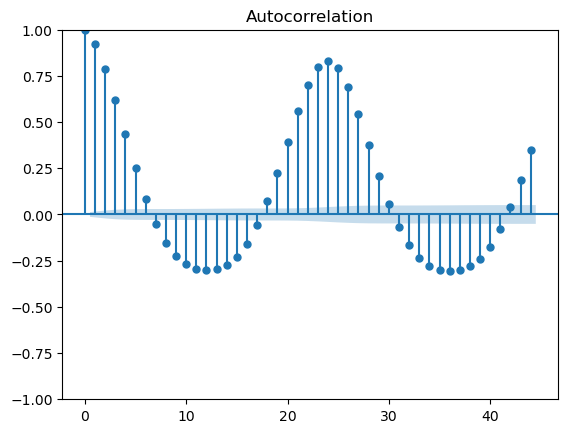

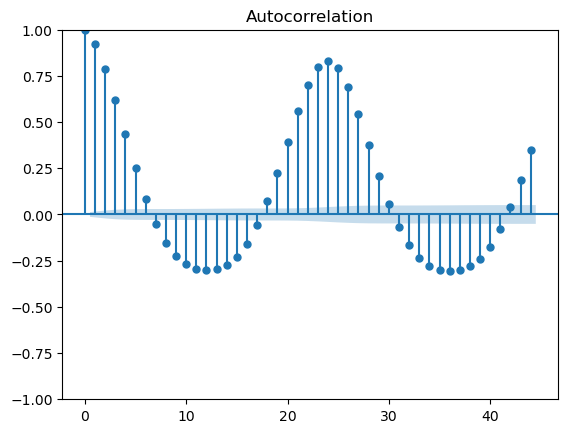

In [6]:
# ARIMA(p, d, q)

# let's look for a suggestion for d by looking at the autocorellation function (ACF) plot

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(solar_radiation_intensity_hourly['SOLAR_RADIATION_INTENSITY'])

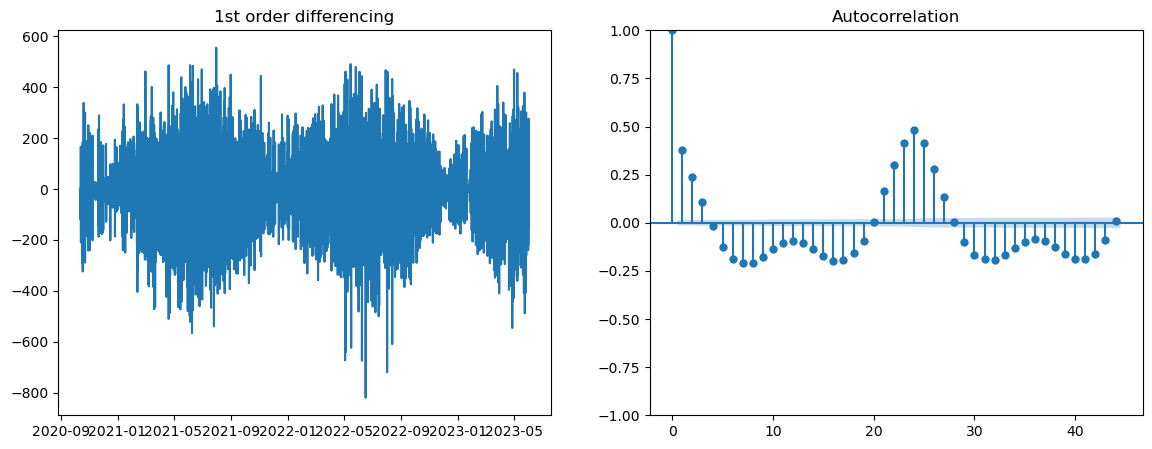

In [7]:
# first differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(solar_radiation_intensity_hourly['SOLAR_RADIATION_INTENSITY'].diff())

ax2 = f.add_subplot(122)
plot_acf(solar_radiation_intensity_hourly['SOLAR_RADIATION_INTENSITY'].diff().dropna(), ax=ax2)
plt.show()


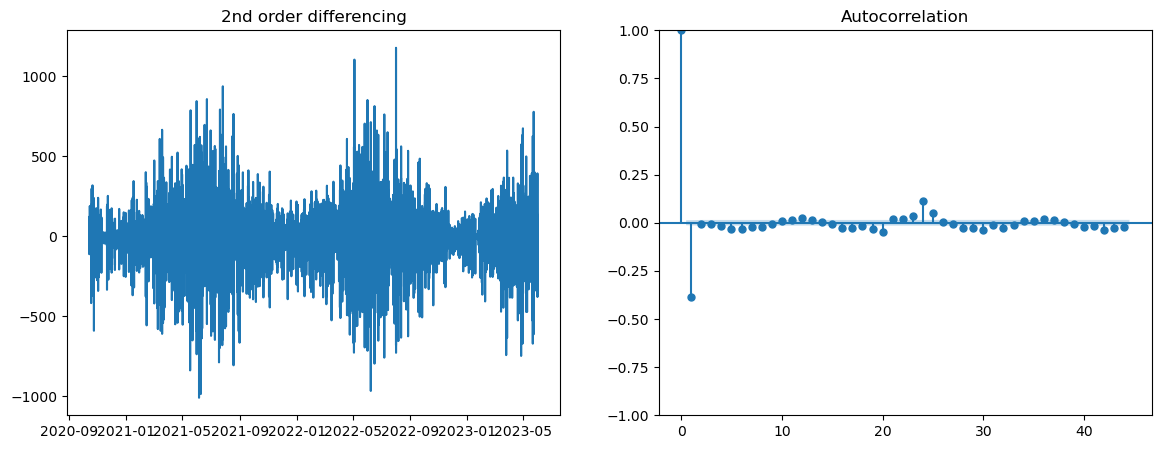

In [8]:
# second differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('2nd order differencing')
ax1.plot(solar_radiation_intensity_hourly['SOLAR_RADIATION_INTENSITY'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(solar_radiation_intensity_hourly['SOLAR_RADIATION_INTENSITY'].diff().diff().dropna(), ax=ax2)
plt.show()

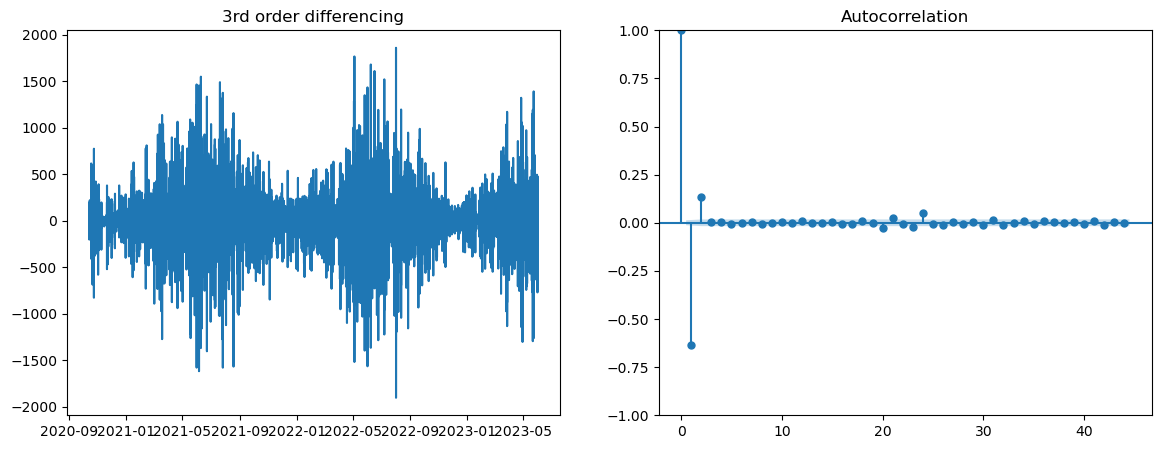

In [9]:
# third differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('3rd order differencing')
ax1.plot(solar_radiation_intensity_hourly['SOLAR_RADIATION_INTENSITY'].diff().diff().diff())

ax2 = f.add_subplot(122)
plot_acf(solar_radiation_intensity_hourly['SOLAR_RADIATION_INTENSITY'].diff().diff().diff().dropna(), ax=ax2)
plt.show()

For deciding the appropriate order of differencind, we can to the Augmented Dickey-Fuller test. (more about it for the report is in the air_pressure files). The ADF test aims to reject the null hypothesis that the given time-series data is non-stationary. It calculates the p-value and compares it with a threshold value or significance level of 0.05. If the p-value is less than this level, then the data is stationary; else, the differencing order is incremented by one.

In [10]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(solar_radiation_intensity_hourly['SOLAR_RADIATION_INTENSITY'].dropna())
print('original data p-value:', result[1])

result = adfuller(solar_radiation_intensity_hourly['SOLAR_RADIATION_INTENSITY'].diff().dropna())
print('1-diff data p-value:', result[1])

result = adfuller(solar_radiation_intensity_hourly['SOLAR_RADIATION_INTENSITY'].diff().diff().dropna())
print('2-diff data p-value:', result[1])

result = adfuller(solar_radiation_intensity_hourly['SOLAR_RADIATION_INTENSITY'].diff().diff().diff().dropna())
print('3-diff data p-value:', result[1])

original data p-value: 1.7422733689387579e-12
1-diff data p-value: 0.0
2-diff data p-value: 0.0
3-diff data p-value: 0.0


The data is likely stationary.

Now we will look for the best ARIMA(p,d,q) model to fit to the data.

In [34]:
# 1ST WAY OF FINDING THE BEST FIT

# ARIMA for all the hourly ambient solar_radiation_intensity data
from pmdarima import auto_arima
stepwise_fit = auto_arima(solar_radiation_intensity_hourly, trace=True,
suppress_warnings=True)
# it takes around 10 min

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=264043.918, Time=17.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=272493.797, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=268935.250, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=269817.226, Time=3.70 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=272491.797, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=268606.262, Time=3.76 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=268652.336, Time=4.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=263687.985, Time=27.84 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=26.18 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=264900.537, Time=34.06 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=264002.619, Time=33.39 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=263691.360, Time=26.21 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=26.40 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=44.49 sec
 ARIMA(3,1,2)(0,0,

                                   SARIMAX Results                                   
Dep. Variable:     SOLAR_RADIATION_INTENSITY   No. Observations:                23052
Model:                        ARIMA(3, 1, 2)   Log Likelihood             -131819.904
Date:                       Wed, 22 May 2024   AIC                         263651.807
Time:                               16:07:21   BIC                         263700.080
Sample:                           10-13-2020   HQIC                        263667.493
                                - 05-31-2023                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.0190      0.005    445.247      0.000       2.010       2.028
ar.L2         -1.2180      0.008   -153.547      0.000      -1.234      -1.

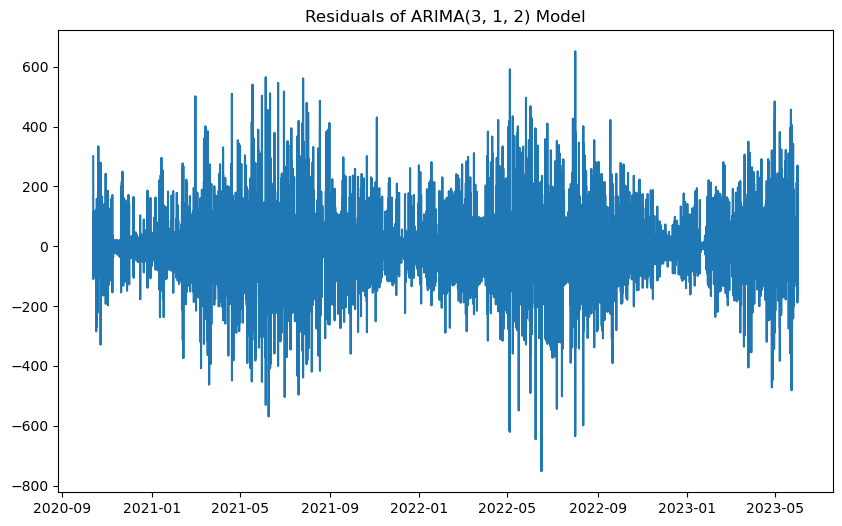

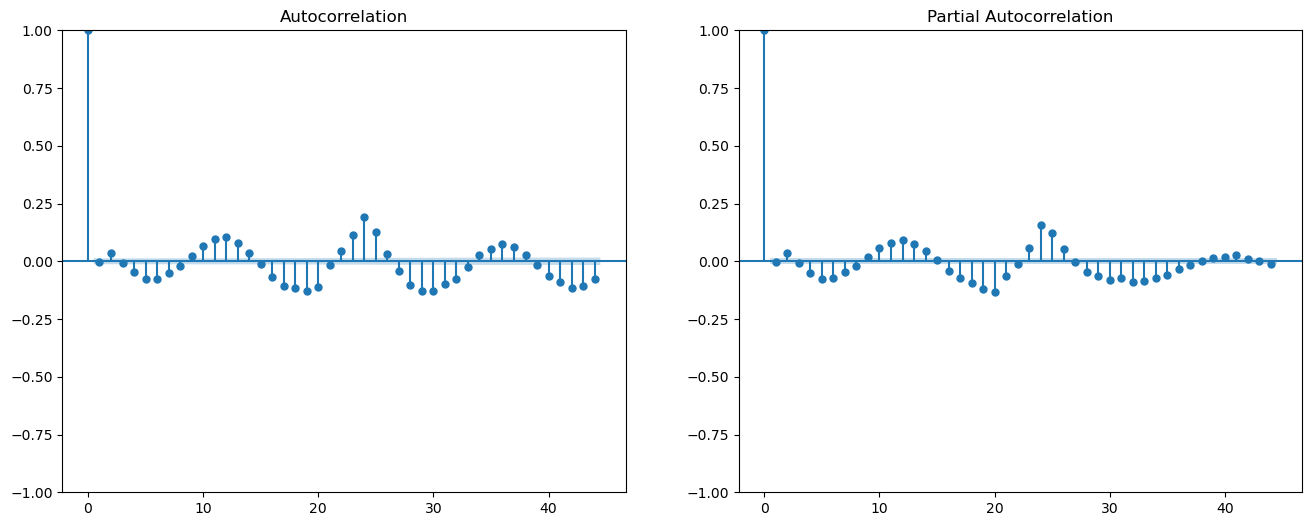

In [11]:
# fit the model 

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# fit the best model
best_model = ARIMA(solar_radiation_intensity_hourly, order=(3,1,2))   # change order accordingly
best_fit = best_model.fit()

# summary of the best model
print(best_fit.summary())

# residuals of the best model
residuals_best = best_fit.resid

# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(residuals_best)
plt.title(f'Residuals of ARIMA{3,1,2} Model')
plt.show()

# plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals_best, ax=ax[0], alpha=0.05)
plot_pacf(residuals_best, ax=ax[1], alpha=0.05)
plt.show()

        Order            AIC            BIC
46  (2, 1, 4)  263623.190021  263679.508272
82  (4, 1, 4)  263637.718822  263710.128002
62  (3, 1, 2)  263651.807269  263700.080056
64  (3, 1, 4)  263667.192686  263731.556402
45  (2, 1, 3)  263689.359953  263737.632739
Best ARIMA order: (2, 1, 4)
                                   SARIMAX Results                                   
Dep. Variable:     SOLAR_RADIATION_INTENSITY   No. Observations:                23052
Model:                        ARIMA(2, 1, 4)   Log Likelihood             -131804.595
Date:                       Mon, 20 May 2024   AIC                         263623.190
Time:                               08:50:24   BIC                         263679.508
Sample:                           10-13-2020   HQIC                        263641.490
                                - 05-31-2023                                         
Covariance Type:                         opg                                         
                 coe

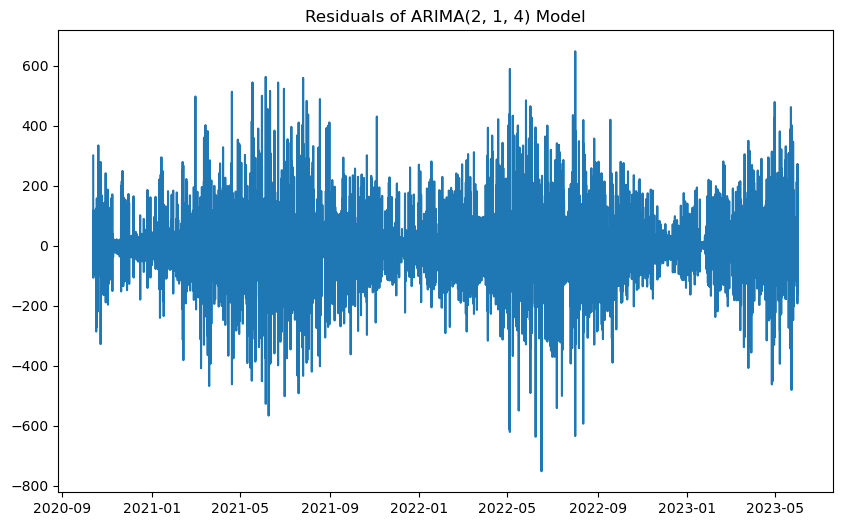

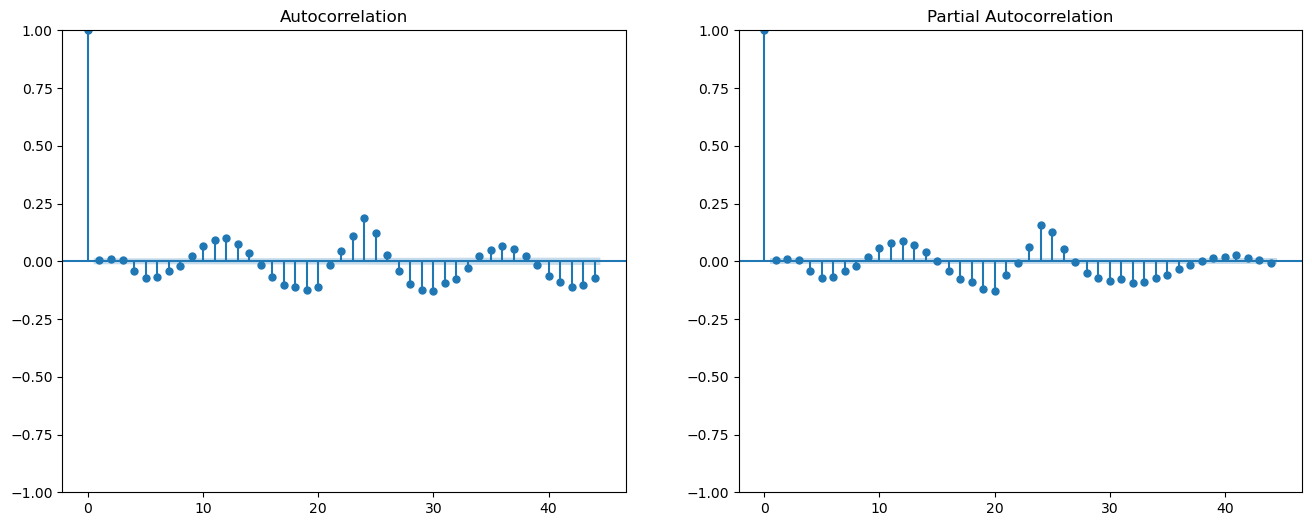

In [35]:
# 2ND WAY OF FINDING THE BEST FIT

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# define the range for p, d, q parameters
p = range(0, 6)
d = range(0, 3)
q = range(0, 6)

# a list to store the results
results = []

# perform grid search
for i in p:
    for j in d:
        for k in q:
            order = (i, j, k)
            try:
                model = ARIMA(solar_radiation_intensity_hourly, order=order)
                fit = model.fit()
                aic = fit.aic
                bic = fit.bic
                results.append((order, aic, bic))
            except:
                continue

# convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Order', 'AIC', 'BIC'])

# sort the results by AIC and BIC
results_df = results_df.sort_values(by='AIC')

# print the top 5 models
print(results_df.head())

# choose the best model based on the lowest AIC
best_order = results_df.iloc[0]['Order']
print(f"Best ARIMA order: {best_order}")

# fit the best model
best_model = ARIMA(solar_radiation_intensity_hourly, order=best_order)
best_fit = best_model.fit()

# check the summary of the best model
print(best_fit.summary())

# residuals of the best model
residuals_best = best_fit.resid

# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(residuals_best)
plt.title(f'Residuals of ARIMA{best_order} Model')
plt.show()

# plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals_best, ax=ax[0])
plot_pacf(residuals_best, ax=ax[1])
plt.show()

In [12]:
# data for 2020, 2021, 2022
# fit the best model to this data
# 2 best ARIMAs: (3,1,2) and (2,1,4) - try both
# forecast the next 24 hours 
# compare forecast from ARIMA and simple model with actual values (maybe 2 simple models)
# plot forecasts, plot errors

solar_radiation_intensity_20_21_22 = solar_radiation_intensity_hourly.loc[(solar_radiation_intensity_hourly.index.year == 2020) | (solar_radiation_intensity_hourly.index.year == 2021) | (solar_radiation_intensity_hourly.index.year == 2022) , 'SOLAR_RADIATION_INTENSITY']
print(solar_radiation_intensity_20_21_22)

2020-10-13 10:00:00+00:00    300.837500
2020-10-13 11:00:00+00:00    258.341667
2020-10-13 12:00:00+00:00    260.816667
2020-10-13 13:00:00+00:00    161.950000
2020-10-13 14:00:00+00:00    155.100000
                                ...    
2022-12-31 19:00:00+00:00     -0.233333
2022-12-31 20:00:00+00:00     -0.191667
2022-12-31 21:00:00+00:00     -0.175000
2022-12-31 22:00:00+00:00     -0.316667
2022-12-31 23:00:00+00:00     -0.216667
Freq: H, Name: SOLAR_RADIATION_INTENSITY, Length: 19430, dtype: float64


Now we will create two simple models to later compare it with the ARIMA models we fitted to the data.

Simple model: Average of the previous 3 days is the value for the next day.

We fitted ARIMA models to all the hourly data. We will fit the models to the data for just 2020, 2021 and 2022 and then forecast 1 day (24 steps into the 'future', which is the start of the year 2023).

We will then compare the models with the actual data and see which model gives the best forecast. Hopefully it is the ARIMA model.

In [13]:
# 1st simple model
# average of the previous 3 days is the value for the next day

def last_3_days_average(data, forecasted_steps):
    # Forecasts the next values based on the average of the last 3 days at the same time.
    forecast = []

    for step in range(forecasted_steps):

        next_time_step = data.index[-1] + pd.Timedelta(hours=1) # finds out the next time step
        
        last_3_days = [
            next_time_step - pd.Timedelta(days=i) for i in range(1, 4)     # gets the same hour from the last 3 days
        ]
        
        values = [data[data.index == dt].values for dt in last_3_days] # extracts the values at the same hour from the last 3 days
        values = [val[0] if len(val) > 0 else np.nan for val in values]
        
        forecast_value = np.nanmean(values) # mean of the last 3 days
        
        forecast.append(forecast_value)
        
        data = pd.concat([data, pd.Series([forecast_value], index=[next_time_step])]) # adds the forecasted value to the data for the next iteration

    return pd.Series(forecast, index=[data.index[-forecasted_steps + i] for i in range(forecasted_steps)])

last_3_days_average(solar_radiation_intensity_20_21_22, 24)

last_3_solar_radiation_intensity = last_3_days_average(solar_radiation_intensity_20_21_22, 24)

In [14]:
# 2nd simple model
# today's measurement is tomorrow's forecast

def today_is_tomorrow(data, forecasted_steps):

    forecast = []

    for step in range(forecasted_steps):

        next_time_step = data.index[-1] + pd.Timedelta(hours=1)
        
        same_hour_last_day = next_time_step - pd.Timedelta(days=1)
        
        forecast_value = data.loc[same_hour_last_day]
        
        forecast.append(forecast_value)
        
        data = pd.concat([data, pd.Series([forecast_value], index=[next_time_step])])

    return pd.Series(forecast, index=[data.index[-forecasted_steps + i] for i in range(forecasted_steps)])

today_is_tomorrow(solar_radiation_intensity_20_21_22, 24)

today_is_tomorrow_solar_radiation_intensity = today_is_tomorrow(solar_radiation_intensity_20_21_22, 24)

In [15]:
# ARIMA(3,1,2) (1st fit)

# change p,d,q to the best found

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# fit
model_312 = ARIMA(solar_radiation_intensity_20_21_22, order=(3,1,2))
fit_312 = model_312.fit()

# summary of the fit
print(fit_312.summary())

# ARIMA forecast for 1 day (24 steps) into the future

forecast_result_312 = fit_312.get_forecast(steps=24)
forecast_values_312 = forecast_result_312.predicted_mean
conf_int_312 = forecast_result_312.conf_int()

print("Forecasted values:", forecast_values_312)
print("95% Confidence intervals of forecasts:", conf_int_312)

                                   SARIMAX Results                                   
Dep. Variable:     SOLAR_RADIATION_INTENSITY   No. Observations:                19430
Model:                        ARIMA(3, 1, 2)   Log Likelihood             -111321.540
Date:                       Wed, 22 May 2024   AIC                         222655.079
Time:                               16:07:34   BIC                         222702.326
Sample:                           10-13-2020   HQIC                        222670.559
                                - 12-31-2022                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.0101      0.006    339.375      0.000       1.998       2.022
ar.L2         -1.2097      0.010   -119.384      0.000      -1.230      -1.

In [16]:
print(forecast_values_312)

2023-01-01 00:00:00+00:00      4.592115
2023-01-01 01:00:00+00:00     13.209541
2023-01-01 02:00:00+00:00     24.727897
2023-01-01 03:00:00+00:00     38.137166
2023-01-01 04:00:00+00:00     52.377683
2023-01-01 05:00:00+00:00     66.412670
2023-01-01 06:00:00+00:00     79.296917
2023-01-01 07:00:00+00:00     90.234551
2023-01-01 08:00:00+00:00     98.622337
2023-01-01 09:00:00+00:00    104.076586
2023-01-01 10:00:00+00:00    106.443019
2023-01-01 11:00:00+00:00    105.790199
2023-01-01 12:00:00+00:00    102.388207
2023-01-01 13:00:00+00:00     96.675109
2023-01-01 14:00:00+00:00     89.214434
2023-01-01 15:00:00+00:00     80.647247
2023-01-01 16:00:00+00:00     71.642480
2023-01-01 17:00:00+00:00     62.849073
2023-01-01 18:00:00+00:00     54.853056
2023-01-01 19:00:00+00:00     48.142136
2023-01-01 20:00:00+00:00     43.079661
2023-01-01 21:00:00+00:00     39.889035
2023-01-01 22:00:00+00:00     38.648878
2023-01-01 23:00:00+00:00     39.298453
Freq: H, Name: predicted_mean, dtype: fl

In [17]:
# ARIMA(2,1,4) (2nd fit)

# change p,d,q to the best found

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")


# fit
model_214 = ARIMA(solar_radiation_intensity_20_21_22, order=(2,1,4))
fit_214 = model_214.fit()

# summary of the fit
print(fit_214.summary())

# ARIMA forecast for 1 day (24 steps) into the future

forecast_result_214 = fit_214.get_forecast(steps=24)
forecast_values_214 = forecast_result_214.predicted_mean
conf_int_214 = forecast_result_214.conf_int()

print("Forecasted values:", forecast_values_214)
print("95% Confidence intervals of forecasts:", conf_int_214)

                                   SARIMAX Results                                   
Dep. Variable:     SOLAR_RADIATION_INTENSITY   No. Observations:                19430
Model:                        ARIMA(2, 1, 4)   Log Likelihood             -111224.933
Date:                       Wed, 22 May 2024   AIC                         222463.865
Time:                               16:07:48   BIC                         222518.987
Sample:                           10-13-2020   HQIC                        222481.925
                                - 12-31-2022                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8671      0.002    828.626      0.000       1.863       1.872
ar.L2         -0.9362      0.002   -399.985      0.000      -0.941      -0.

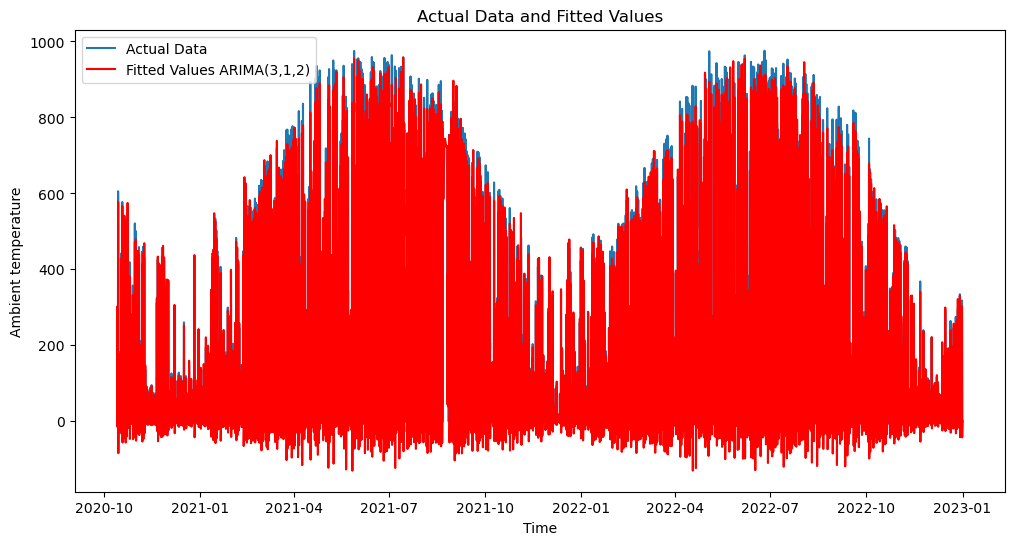

In [18]:
# plot actual data and fitted values - 1ST ARIMA
# change p,d,q to the best found

# fitted values
fitted_values_312 = fit_312.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(solar_radiation_intensity_20_21_22.index, solar_radiation_intensity_20_21_22, label='Actual Data')
plt.plot(solar_radiation_intensity_20_21_22.index, fitted_values_312, color='red', label='Fitted Values ARIMA(3,1,2)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ambient temperature')
plt.title('Actual Data and Fitted Values')
plt.show()

# this looks too good

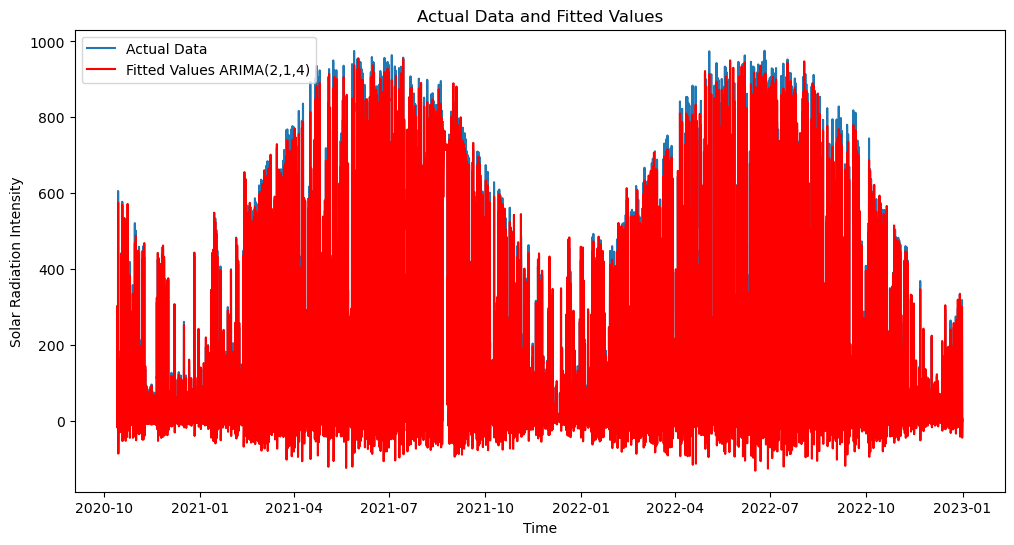

In [19]:
# plot actual data and fitted values - 2ND ARIMA
# change p,d,q to the best found

# fitted values
fitted_values_214 = fit_214.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(solar_radiation_intensity_20_21_22.index, solar_radiation_intensity_20_21_22, label='Actual Data')
plt.plot(solar_radiation_intensity_20_21_22.index, fitted_values_214, color='red', label='Fitted Values ARIMA(2,1,4)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Solar Radiation Intensity')
plt.title('Actual Data and Fitted Values')
plt.show()

# this looks too good

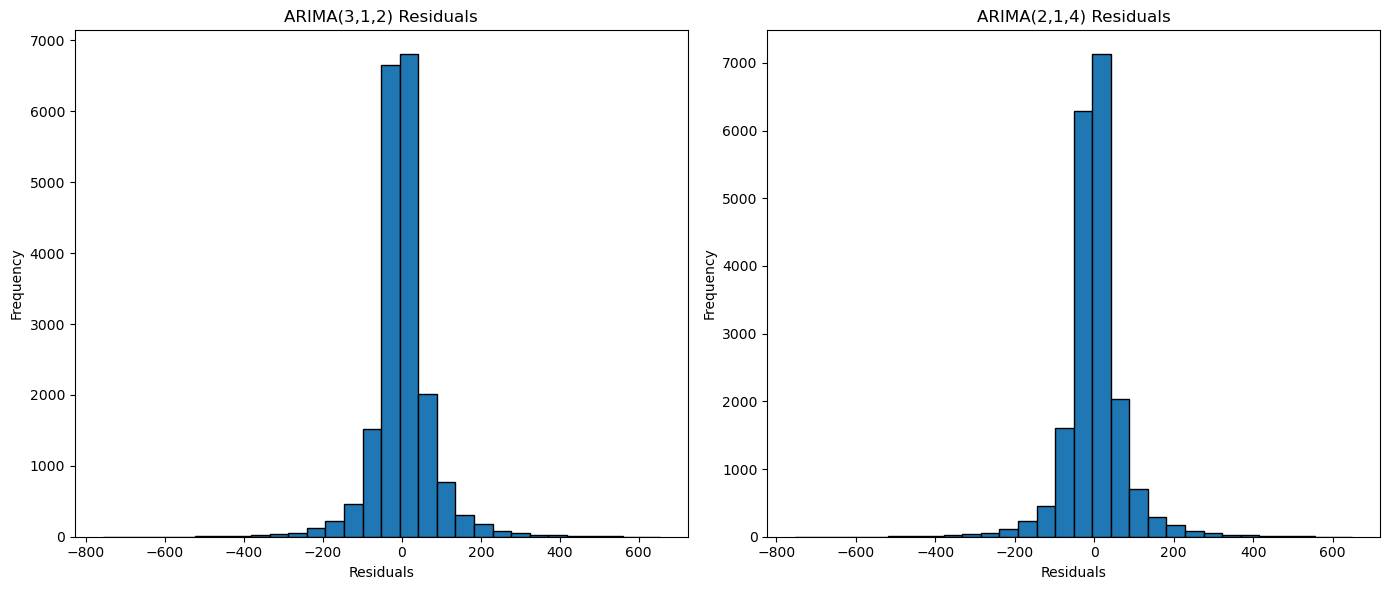

In [20]:
# comparison of the histograms

# residuals
residuals_312 = fit_312.resid
residuals_214 = fit_214.resid

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(residuals_312, bins=30, edgecolor='k')
plt.title('ARIMA(3,1,2) Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(residuals_214, bins=30, edgecolor='k')
plt.title('ARIMA(2,1,4) Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')



plt.tight_layout()
plt.show()


The residuals in a time series model are what is left over after fitting a model. The residuals are equal to the difference between the observations and the corresponding fitted values.

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will have residuals with the following properties:

1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

In [33]:
# statistical test and metricts to determine which model is better

import math 
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

# mean of the residuals (should be 0)
mean1 = np.mean(residuals_312)
mean2 = np.mean(residuals_214)
print(mean1, mean2)

# AIC (already done above) - writte about AIC in the report
aic1 = fit_312.aic
aic2 = fit_214.aic
print(aic1, aic2)
# lower is better
if aic1 < aic2:
    print('ARIMA(3,1,2) is better based on AIC.')
else:
    print('ARIMA(2,1,4) is preferred based on AIC.')

# Ljung-Box test for autocorrelation - see model fit output

# BIC - see model fit output

-0.01122033722321675 -0.0013341927451245993
222655.07906692493 222463.8654243723
ARIMA(2,1,4) is preferred based on AIC.


Mean Absolute Error: 44.6020960250649
Mean Squared Error: 5498.249334036698


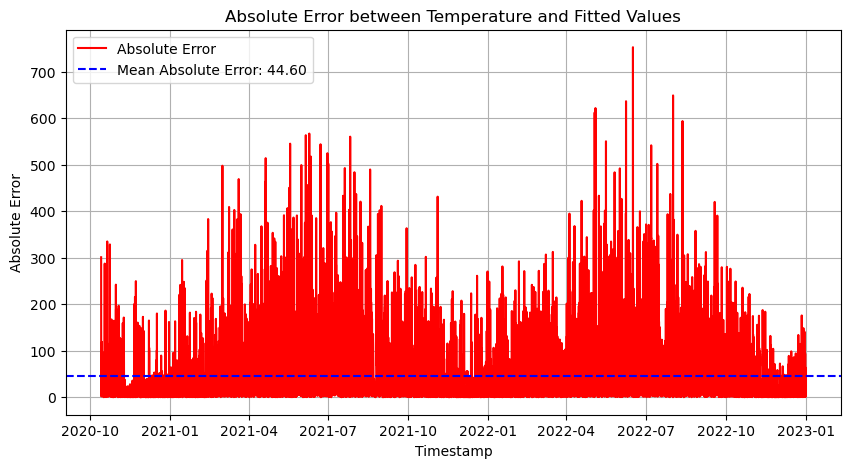

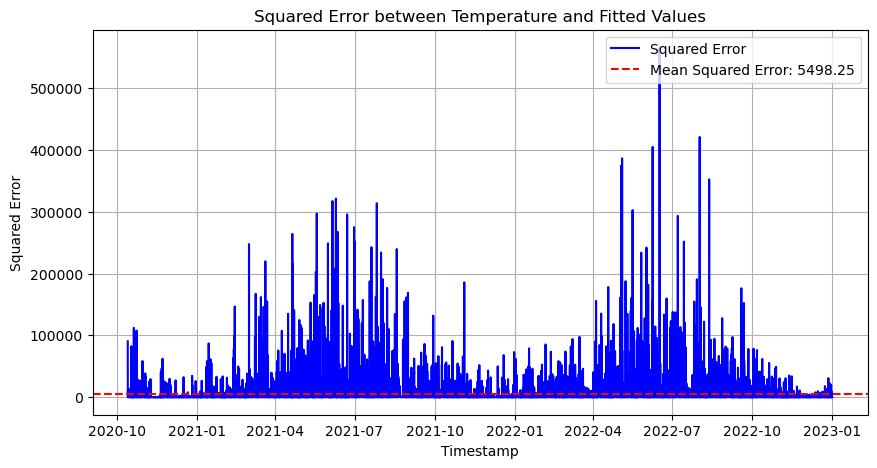

In [22]:
# Absolute error measurements

# absolute error comparison - actual data vs fitted model data

def calculate_errors(data, model): 
      # model are fitted values of a chosen model
  if isinstance(data, pd.Series) and isinstance(model, pd.Series):
        absolute_error = (data - model).abs()
        squared_error = (data - model) ** 2
  elif isinstance(data, np.ndarray) and isinstance(model, np.ndarray):
        absolute_error = np.abs(data - model)
        squared_error = (data - model) ** 2
  errors = pd.DataFrame({
        'absolute_error': absolute_error,
        'squared_error': squared_error
  })

  return errors

# (2,1,4) is the preferred, lets compare this data with actual data
# actual data - temperature_20_21_22
# fitted values data - fitted_values_214 

errors = calculate_errors(solar_radiation_intensity_20_21_22, fitted_values_214 )

# mean errors
mean_absolute_error = errors['absolute_error'].mean()
mean_squared_error = errors['squared_error'].mean()
print("Mean Absolute Error:", mean_absolute_error)
print("Mean Squared Error:", mean_squared_error)

# plot of the absolute error
plt.figure(figsize=(10, 5))
plt.plot(errors['absolute_error'], label='Absolute Error', color='red')
plt.axhline(y=mean_absolute_error, color='blue', linestyle='--', label=f'Mean Absolute Error: {mean_absolute_error:.2f}')
plt.xlabel('Timestamp')
plt.ylabel('Absolute Error')
plt.title('Absolute Error between Temperature and Fitted Values')
plt.legend()
plt.grid(True)
plt.show()

# plot of the squared error
plt.figure(figsize=(10, 5))
plt.plot(errors['squared_error'], label='Squared Error', color='blue')
plt.axhline(y=mean_squared_error, color='red', linestyle='--', label=f'Mean Squared Error: {mean_squared_error:.2f}')
plt.xlabel('Timestamp')
plt.ylabel('Squared Error')
plt.title('Squared Error between Temperature and Fitted Values')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
    

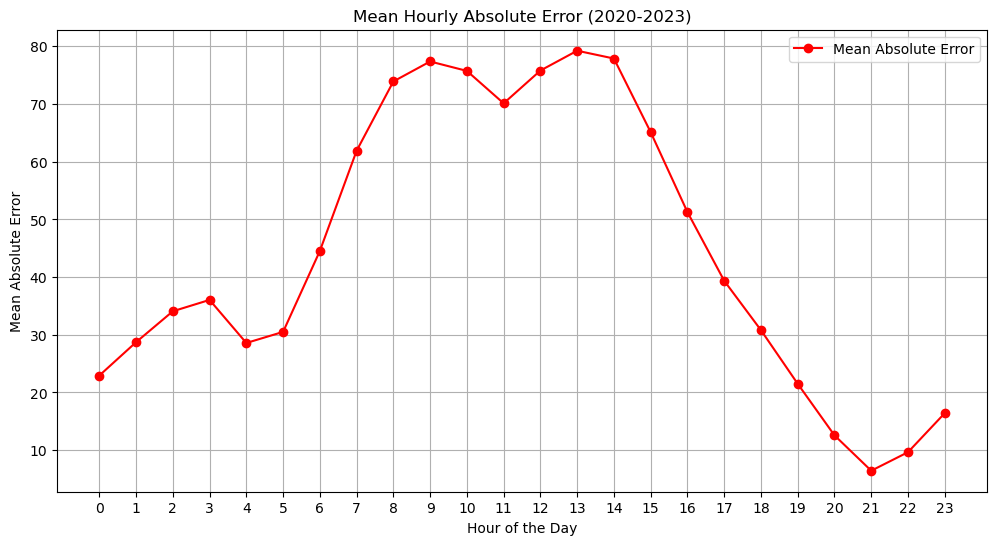

Hour
0     22.925087
1     28.709829
2     34.072631
3     36.040294
4     28.574662
5     30.497826
6     44.526003
7     61.901794
8     73.918957
9     77.378830
10    75.746461
11    70.124307
12    75.806866
13    79.245412
14    77.891810
15    65.122418
16    51.268644
17    39.359851
18    30.795797
19    21.497843
20    12.560097
21     6.426565
22     9.641343
23    16.407749
Name: absolute_error, dtype: float64


In [23]:
# mean hourly absolute errors

errors['Hour'] = errors.index.hour

# mean
mean_absolute_errors_by_hour = errors.groupby('Hour')['absolute_error'].mean()

# plot
plt.figure(figsize=(12, 6))
plt.plot(mean_absolute_errors_by_hour.index, mean_absolute_errors_by_hour, label='Mean Absolute Error', marker='o', color='red')

plt.xlabel('Hour of the Day')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Hourly Absolute Error (2020-2023)')
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(range(24))
plt.show()

print(mean_absolute_errors_by_hour)

In [24]:
# actual measurements for 1 day (24 steps) into the future
radio_hourly = solar_radiation_intensity_hourly['SOLAR_RADIATION_INTENSITY']
actual_values_solar_radiation_intensity_23 = radio_hourly['2023'].head(24)
print(actual_values_solar_radiation_intensity_23)

2023-01-01 00:00:00+00:00     -0.108333
2023-01-01 01:00:00+00:00     -0.100000
2023-01-01 02:00:00+00:00     -0.300000
2023-01-01 03:00:00+00:00     -0.158333
2023-01-01 04:00:00+00:00     -0.191667
2023-01-01 05:00:00+00:00     -0.091667
2023-01-01 06:00:00+00:00      1.766667
2023-01-01 07:00:00+00:00     36.225000
2023-01-01 08:00:00+00:00    102.000000
2023-01-01 09:00:00+00:00    274.133333
2023-01-01 10:00:00+00:00    324.416667
2023-01-01 11:00:00+00:00    256.583333
2023-01-01 12:00:00+00:00    283.283333
2023-01-01 13:00:00+00:00    190.108333
2023-01-01 14:00:00+00:00     51.250000
2023-01-01 15:00:00+00:00      2.791667
2023-01-01 16:00:00+00:00     -0.508333
2023-01-01 17:00:00+00:00     -0.675000
2023-01-01 18:00:00+00:00     -0.400000
2023-01-01 19:00:00+00:00     -0.400000
2023-01-01 20:00:00+00:00     -0.358333
2023-01-01 21:00:00+00:00     -0.433333
2023-01-01 22:00:00+00:00     -0.491667
2023-01-01 23:00:00+00:00     -0.200000
Freq: H, Name: SOLAR_RADIATION_INTENSITY

                               Actual  ARIMA(3,1,2)  ARIMA(2,1,4)  \
2023-01-01 00:00:00+00:00   -0.108333      4.592115      9.657011   
2023-01-01 01:00:00+00:00   -0.100000     13.209541     24.523112   
2023-01-01 02:00:00+00:00   -0.300000     24.727897     42.872213   
2023-01-01 03:00:00+00:00   -0.158333     38.137166     62.920407   
2023-01-01 04:00:00+00:00   -0.191667     52.377683     83.174146   
2023-01-01 05:00:00+00:00   -0.091667     66.412670    102.220984   
2023-01-01 06:00:00+00:00    1.766667     79.296917    118.821988   
2023-01-01 07:00:00+00:00   36.225000     90.234551    131.986267   
2023-01-01 08:00:00+00:00  102.000000     98.622337    141.023598   
2023-01-01 09:00:00+00:00  274.133333    104.076586    145.572937   
2023-01-01 10:00:00+00:00  324.416667    106.443019    145.606349   
2023-01-01 11:00:00+00:00  256.583333    105.790199    141.409689   
2023-01-01 12:00:00+00:00  283.283333    102.388207    133.542828   
2023-01-01 13:00:00+00:00  190.108

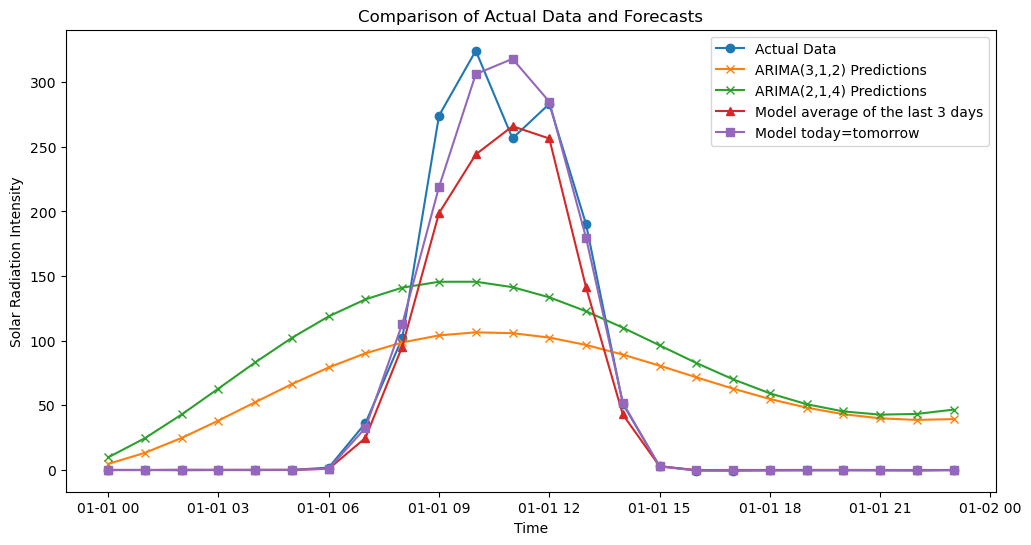

In [31]:
# comparing the models with the actual data
# change p,d,q to the best found

comparison_solar_radiation_intensity = pd.DataFrame({
    'Actual': actual_values_solar_radiation_intensity_23,
    'ARIMA(3,1,2)': forecast_values_312,
    'ARIMA(2,1,4)': forecast_values_214,
    'Model average of the last 3 days': last_3_solar_radiation_intensity,
    'Model today=tomorrow': today_is_tomorrow_solar_radiation_intensity
})

print(comparison_solar_radiation_intensity)

plt.figure(figsize=(12,6))

plt.plot(comparison_solar_radiation_intensity.index, comparison_solar_radiation_intensity['Actual'], label='Actual Data', marker='o')
plt.plot(comparison_solar_radiation_intensity.index, comparison_solar_radiation_intensity['ARIMA(3,1,2)'], label='ARIMA(3,1,2) Predictions', marker='x')
plt.plot(comparison_solar_radiation_intensity.index, comparison_solar_radiation_intensity['ARIMA(2,1,4)'], label='ARIMA(2,1,4) Predictions', marker='x')
plt.plot(comparison_solar_radiation_intensity.index, comparison_solar_radiation_intensity['Model average of the last 3 days'], label='Model average of the last 3 days', marker='^')
plt.plot(comparison_solar_radiation_intensity.index, comparison_solar_radiation_intensity['Model today=tomorrow'], label='Model today=tomorrow', marker='s')

plt.xlabel('Time')
plt.ylabel('Solar Radiation Intensity')
plt.title('Comparison of Actual Data and Forecasts')
plt.legend()
plt.show()

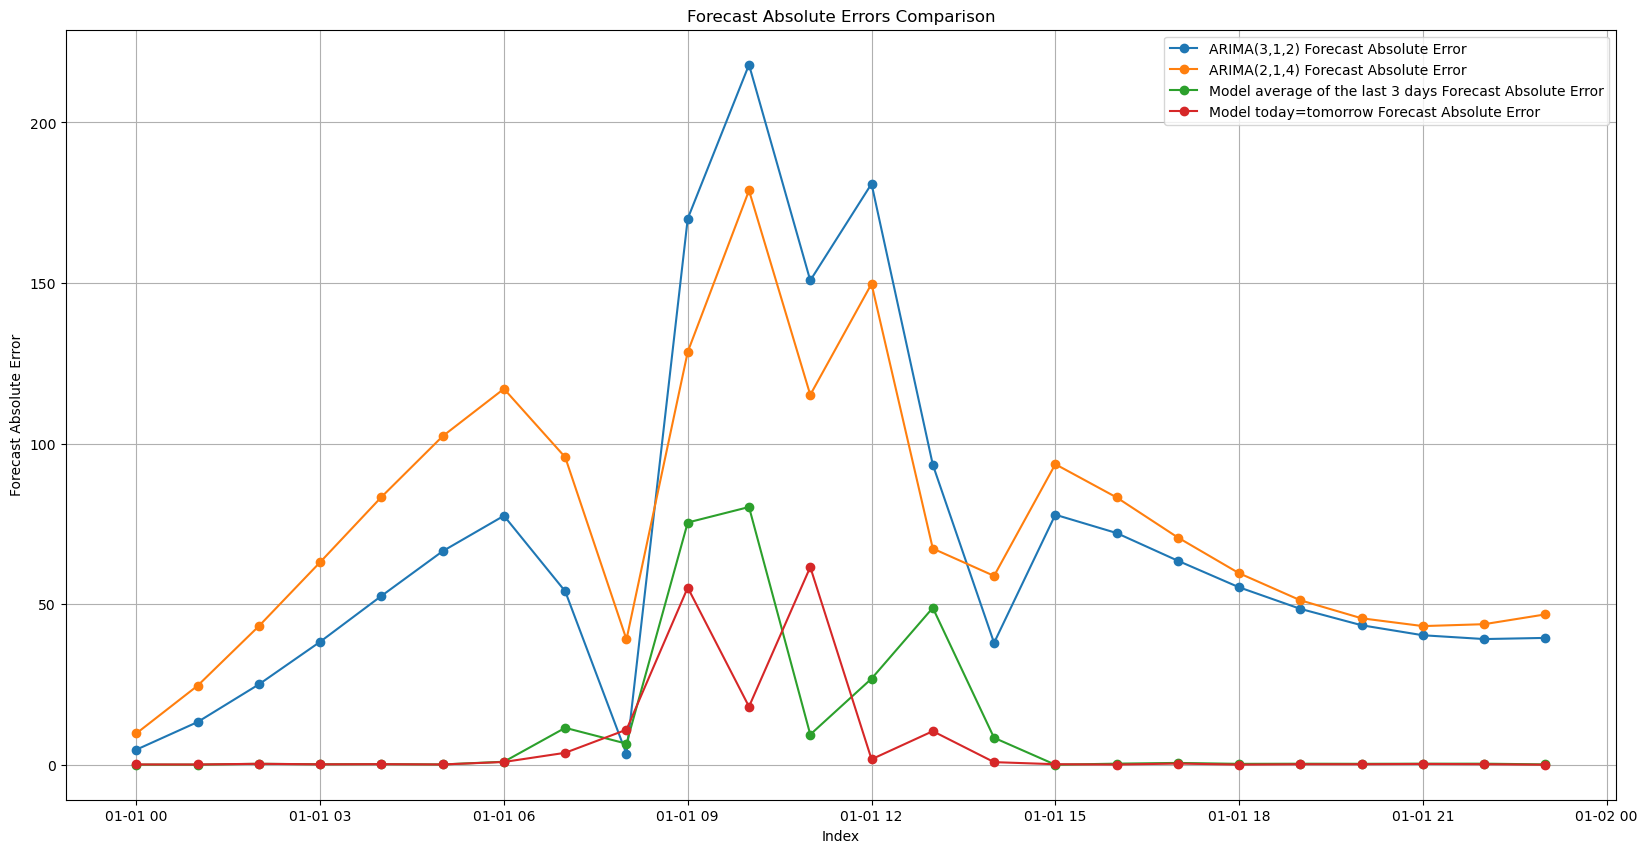

ARIMA(3,1,2) Forecast Absolute Error                        69.423578
ARIMA(2,1,4) Forecast Absolute Error                        75.599554
Model average of the last 3 days Forecast Absolute Error    11.315625
Model today=tomorrow Forecast Absolute Error                 6.901389
dtype: float64


In [26]:
# 4 models' predictions compared to the actual data

# absolute errors of all the modela
forecast_absolute_errors = pd.DataFrame()
for column in comparison_solar_radiation_intensity.columns:
    if column != 'Actual':
        forecast_absolute_errors[column + ' Forecast Absolute Error'] = (comparison_solar_radiation_intensity['Actual'] - comparison_solar_radiation_intensity[column]).abs()

# plot
plt.figure(figsize=(20, 10))
for column in forecast_absolute_errors.columns:
    plt.plot(forecast_absolute_errors[column], label=column, marker='o')

plt.xlabel('Index')
plt.ylabel('Forecast Absolute Error')
plt.title('Forecast Absolute Errors Comparison')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# values 
#print(forecast_absolute_errors)

# mean errors
print(forecast_absolute_errors.mean())
